# **Portfolio Optimizer (Work in Progress)**
## **Contents**
1. [Introduction](#Introduction)
2. [Portfolio Metrics](#Modern-Portfolio-Theory)
   - [Portfolio Expected Return](#Portfolio-Expected-Return)
   - [Portfolio Covariance](#Portfolio-Covariance)
   - [Portfolio Variance and Volatility](#Portfolio-Variance-and-Volatility)
   - [Portfolio Sharpe Ratio](#Portfolio-Sharpe-Ratio)
3. [Portfolio Weightings](#Portfolio-Weightings)
   - [Equal-Weighted Portfolio](#Equal-Weighted-Portfolio)
   - [Minimum Volatility Portfolio](#Minimum-Volatility-Portfolio)
   - [Maximum Expected Return Portfolio](#Maximum-Expected-Return-Portfolio)
   - [Maximum Sharpe Ratio Portfolio](#Maximum-Sharpe-Ratio-Portfolio)
   - [Inverse-Volatility-Weighted Portfolio](#Minimum-Volatility-Portfolio)
4. [Efficient Frontier Construction](#Efficient-Frontier-Construction)
   - [Simulations](#Simulations)
   - [Minimum Volatility and Maximum Sharpe Ratio Portfolios](#Minimum-Volatility-and-Maximum-Sharpe-Ratio-Portfolios)
1. [Credits](#Credits)


## **Introduction**
This project aims to offer a set portfolio optimization tools for portfolios with risk-bearing financial assets. In particular, several portfolio metrics are defined, as are several different portfolio weightings, where the some of the latter are deduced as solutions to optimization problems. The efficient frontier of portfolios is also introduced and constructed. The `time`, `datetime`, `numpy`, `scipy`, `pandas`, `yfinance`, `matplotlib`, `seaborn` and `warnings` libraries are imported for all the numerical calculations and data analysis/visualisation techniques needed for the purposes of this project. Moreover, the plot styles are set for aesthetic reasons. Finally, when optimising the portfolio weightings, the `scipy.optimize.minimize` method is used and the capital bidget and long-only constrants are applied (i.e., all weights in a portfolio must be positive and sum up to one).

In [74]:
import time as tm
import datetime as dt
import numpy as np
import scipy as sp
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style(style = "whitegrid", rc = {"font.family":"Times New Roman", "font.weight":"bold"})
warnings.simplefilter(action='ignore', category=FutureWarning)

## **Portfolio Metrics**
In a portfolio of assets, there are several specific metrics that can be measured, which also give insight to the performance of the portfolio. In what follows, some of these metrics are defined, using the formalism of probability theory. Moreover, the Python implementation of each of those metrics is also given.

Let $(\Omega, \mathscr{F}, \mathbb{P})$ be a probability space, let $n$ be a non-zero natural number in $\mathbb{N}^{*}$, let $\mathbf{\vec{R}}$ be a $\mathbb{R}_{+}^{n}$-valued random vector on $(\Omega, \mathscr{F}, \mathbb{P})$, and let $\mathbf{\vec{w}}$ be a Euclidean vector in $[0, 1]^{n}$ such that $\sum_{k=1}^{n}w_{k} = 1$. Moreover, consider a portfolio of $n$ risk-bearing assets, having rates of return accodring to the Euclidean vector $\mathbf{\vec{R}}$ and respectively distributed according to the components of the Euclidean vector $\mathbf{\vec{w}}$.

### **Portfolio Expected Return**
- The *rate of return* of the portfolio is the random variable denoted by $R$ and defined by:
$$\forall \omega \in \Omega, \enspace R(\omega) = \mathbf{\vec{w}} \bullet \mathbf{\vec{R}}(\omega) = \sum_{k = 1}^{n}w_{k}\cdot R_{k}(\omega)$$
- The *expected return vector* of the portfolio is the Euclidean vector denoted by $\mathbf{\vec{\mu}}$ and defined by:
$$\mathbf{\vec{\mu}} = \mathbb{E}\left(\mathbf{\vec{R}}\right) = \left(\mathbb{E}(R_{k})\right)_{k=1}^{n}$$
- The *expected rate of return* of the portfolio is the real number denoted by $\mu$ and defined by:
$$\mu = \mathbf{\vec{w}} \bullet \mathbf{\vec{\mu}} = \sum_{k = 1}^{n}w_{k}\cdot \mu_{k} = \sum_{k = 1}^{n}w_{k}\cdot \mathbb{E}(R_{k})$$
The Python implementation of the expected rate of return of a portfolio is given in the code cell below.

In [75]:
def expected_return(tickers, start_date, end_date, weights = None, frequency = 1):
    n = len(tickers)
    if weights is None:
        weights = np.ones(n) / n
    else:
        pass
    assert type(tickers) is list and len(tickers) > 0
    prices = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Adj Close"]
    returns = prices.pct_change()
    expected_returns = returns.mean() * frequency
    portfolio_expected_return = np.dot(weights, expected_returns.T)
    return portfolio_expected_return

tickers = ["AAPL", "GOOG", "MSFT"]
end_date = "2024-01-01"
start_date = "2022-01-01"

expected_return(tickers, start_date, end_date)

0.00031446844897462905

### **Portfolio Covariance**
- The *return covariance* of the portfolio is the matrix denoted by $\mathbf{\Sigma}$ and defined by:
$$\mathbf{\Sigma} = \left[\mathbf{Cov}\left(R_{j}, R_{k}\right)\right]_{(j, k) \in [[ 1, n ]]^{2}}$$
The Python implementation of the return covariance of a portfolio is given in the code cell below.

In [76]:
def covariance(tickers, start_date, end_date):
    assert type(tickers) is list and len(tickers) > 0
    prices = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Adj Close"]
    returns = prices.pct_change()
    portfolio_covariance = np.array(returns.cov())
    return portfolio_covariance

tickers = ["AAPL", "GOOG", "MSFT"]
end_date = "2024-01-01"
start_date = "2022-01-01"

covariance(tickers, start_date, end_date)

array([[0.00033547, 0.00028337, 0.00026264],
       [0.00028337, 0.0004872 , 0.0003114 ],
       [0.00026264, 0.0003114 , 0.00037463]])

### **Portfolio Variance and Volatility**
- The *return variance* of the portfolio is the positive real number denoted by $\mathbb{V}\left(R\right)$ and defined by:
$$\mathbb{V}\left(R\right) = \mathbf{\vec{w}} \times \mathbf{\Sigma}\times\mathbf{\vec{w}}^{\mathsf{T}}$$
- The *volatility* of the portfolio is the positive real number denoted by $\sigma\left(R\right)$ and defined by:
$$\sigma\left(R\right) = \sqrt{\mathbb{V}\left(R\right)}$$
The Python implementation of the return variance and the volatility of the portfolio a portfolio is given in the code cells below.

In [77]:
def variance(tickers, start_date, end_date, weights = None, frequency = 1):
    n = len(tickers)
    if weights is None:
        weights = np.ones(n) / n
    else:
        pass
    assert type(tickers) is list and len(tickers) > 0
    portfolio_covariance = covariance(tickers, start_date, end_date)
    portfolio_variance = np.dot(np.dot(weights, portfolio_covariance), weights.T) * frequency
    return portfolio_variance

tickers = ["AAPL", "GOOG", "MSFT"]
end_date = "2024-01-01"
start_date = "2022-01-01"

variance(tickers, start_date, end_date)

0.00032356886285544583

In [78]:
def volatility(tickers, start_date, end_date, weights = None, frequency = 1):
    return np.sqrt(variance(tickers, start_date, end_date, weights, frequency))

tickers = ["AAPL", "GOOG", "MSFT"]
end_date = "2024-01-01"
start_date = "2022-01-01"

volatility(tickers, start_date, end_date)

0.01798801998151675

### **Portfolio Sharpe Ratio**
Let $(r, \rho)$ be an ordered pair of strictly positive real numbers in $\mathbb{R}_{+}^{\ast} \times ]0, 1[$, suppose that the portfolio contains, in addition to the $n$ original risk-bearing assets, one riskless asset with rate of return $r$ and having proportion $\rho$ in the portfolio distribution of assets and let $\mathbf{\vec{v}}$ be the Euclidean vector representing the newly constructed portfolio's distribution of assets, defined by:
$$\mathbf{\vec{v}} = \left(\left(1 - \rho\right) \cdot w_{1}, \left(1 - \rho\right) \cdot w_{2}, \dots, \left(1 - \rho\right) \cdot w_{n}, \rho\right)$$
- The *Sharpe ratio* of the newly-constructed portfolio is the positive real number denoted by $\mathrm{Sharpe}\left(R, r\right)$ and defined by:
$$\mathrm{Sharpe}\left(R, r\right) = \frac{\mathbb{E}\left(R - r\right)}{\sigma\left(R - r\right)}$$
The Python implementation of the Sharpe ratio of a portfolio and a riskless asset is given in the code cell below.

In [79]:
def sharpe_ratio(tickers, start_date, end_date, weights = None, frequency = 1, risk_free_rate = 0.02):
    n = len(tickers)
    if weights is None:
        weights = np.ones(n) / n
    else:
        pass
    assert type(tickers) is list and len(tickers) > 0
    prices = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Adj Close"]
    returns = prices.pct_change()
    portfolio_returns = returns.dot(weights)
    adjusted_portfolio_returns = portfolio_returns * frequency
    adjusted_risk_free_rate = risk_free_rate * frequency
    excess_returns = adjusted_portfolio_returns - adjusted_risk_free_rate
    expected_excess_return = excess_returns.mean()
    excess_return_volaitlity = excess_returns.std()
    portfolio_sharpe_ratio = expected_excess_return / excess_return_volaitlity
    return portfolio_sharpe_ratio

tickers = ["AAPL", "GOOG", "MSFT"]
end_date = "2024-01-01"
start_date = "2022-01-01"

sharpe_ratio(tickers, start_date, end_date)

-1.0943690062192983

## **Portfolio Weightings**
Given the Euclidean vector $\mathbf{\vec{R}}$ of rates of returns of the risky assets in the portfolio, as well as the Euclidean vector $\mathbf{\vec{w}}$ of weights in the distribution of assets in the portfolio, completely determine the expected return $\mu$ and the volatility $\sigma$ of the portfolio. By extension, they also uniquely determines the Sharpe ratio $\mathrm{Sharpe}(R, r)$ of the portfolio. Given the Euclidean vector $\mathbf{R}$, it is often desirable to select the value of the Euclidean vector $\mathbf{\vec{w}}$ in such a way that $\mu$ is as high as possible, or that $\sigma$ is as low as possible, pending certain conditions being satisfied. That is, it is desirable to select the value of the Euclidean vector $\mathbf{\vec{w}}$ which solves specific optimization problems in $\mathbf{\vec{w}}$, which are expressed in terms of $\mathbf{\vec{w}}$, $\mathbf{\Sigma}$, $\mu$, $\sigma$, and/or $r$. Such selections are *portfolio weightings* (or *portfolio allocations*, or *asset allocations*), of which several stand out.

### **Equal-Weighted Portfolio**
The equal-weighted portfolio is the portfolio wherein all components of the Euclidean vector $\mathbf{\vec{w}}$ are equal:
$$\mathbf{\vec{w}} = \left(\frac{1}{n}\right)_{k = 1}^{n}$$
The Python implementation for constructing an equal-weighted portfolio is given in the code cell below.

In [80]:
def equal_weighted(tickers, start_date = None, end_date = None):
    assert type(tickers) is list and len(tickers) > 0
    n = len(tickers)
    w = np.ones(n) / n
    return w

tickers = ["AAPL", "GOOG", "MSFT"]
end_date = "2024-01-01"
start_date = "2022-01-01"

equal_weighted(tickers, start_date, end_date)

array([0.33333333, 0.33333333, 0.33333333])

### **Inverse-Volatility-Weighted Portfolio**
The inverse-volatility-weighted portfolio is the portfolio wherein the components of the Euclidean vector $\mathbf{\vec{w}}$ are inversely proportional to their corresponding asset volatilities:
$$\left(\forall k \in [[ 1, n ]], \enspace \sigma_{k} = \sigma\left(R_{k}\right)\right) \implies \mathbf{\vec{w}} = \left(\dfrac{\frac{1}{\sigma_{k}}}{\sum_{j=1}^{n}\frac{1}{\sigma_{j}}}\right)_{k = 1}^{n}$$
The Python implementation for constructing an inverse-volatility-weighted portfolio is given in the code cell below.

In [81]:
def inverse_volatility_weighted(tickers, start_date, end_date):
    assert type(tickers) is list and len(tickers) > 0
    data = yf.download(tickers, start_date, end_date, progress = False)
    S = data["Adj Close"]
    R = S.pct_change()
    sigma = R.std()
    I = np.divide(1, sigma)
    w = np.array(np.divide(I, np.sum(I)))
    return w

tickers = ["AAPL", "GOOG", "MSFT"]
end_date = "2024-01-01"
start_date = "2022-01-01"

inverse_volatility_weighted(tickers, start_date, end_date)

array([0.3602183 , 0.29891035, 0.34087134])

### **Maximum Expected Return Portfolio**
The maximum expected return portfolio is the portfolio wherein the Euclidean vector $\mathbf{\vec{w}}$ maximizes the value of the expected return $\mu$ subject to an upper bound $\sigma_{\ast}$ on $\sigma$, that is, the Euclidean vector $\mathbf{\vec{w}}$ satisfies:
$$\mathbf{\vec{w}} \in \displaystyle \mathrm{argmax}_{\substack{\mathbf{\vec{x}} \in \left[0, 1\right]^{n} \\ \sigma(\mathbf{\vec{x}}) \leqslant \sigma_{\ast} \\ \sum_{k=1}^{n}x_{k} = 1}}\left(\mu\left(\mathbf{\vec{x}}\right)\right)$$
where $\mu$ is the function defined by:
$$\begin{array}{c|ccc} \mu \colon  &   \left\{\mathbf{\vec{x}} \in \left[0, 1\right]^{n} \colon \enspace \sum_{k=1}^{n}x_{k} = 1\right\}    &   \longrightarrow &   \mathbb{R} \\
&   \mathbf{\vec{w}}                                                                                    &   \longmapsto     &   \mathbf{\vec{w}} \bullet \mathbf{\vec{\mu}}
\end{array}$$
or, equivalently, solves the following quadratic program:
\begin{align*}
\textrm{maximize}   \quad   &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\vec{\mu}}                                                 \\
\textrm{subject to} \quad   &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\Sigma} \times \mathbf{\vec{w}} \leqslant \sigma_{\ast}^2, \\
                            &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\vec{1}} = 1,                                              \\
                            &   \mathbf{\vec{w}} \geqslant \mathbf{\vec{0}}
\end{align*}
Given the long-only constraint (i.e., all components of the Euclidean vector $\mathbf{\vec{w}}$ are positive), this quadratic program has no known closed-form solution, and should therefore be solved numerically. The Python implementation for constructing a maximum expected return portfolio is given in the code cell below.

In [82]:
def maximum_expected_return_weighted(tickers, start_date, end_date, sigma_ast, frequency = 1):
    n = len(tickers)
    def objective(w):
        return -expected_return(tickers, start_date, end_date, w, frequency)
    constraints = (
        {"type" : "ineq", "fun" : lambda v: sigma_ast**2 - variance(tickers, start_date, end_date, v, frequency)},
        {"type" : "eq", "fun" : lambda v: np.sum(v) - 1},
        {"type" : "ineq", "fun" : lambda v: np.min(v)}
        )
    bounds = n * ((0, 1),)
    initial_guess = np.divide(np.ones(n), n)
    result = sp.optimize.minimize(objective, initial_guess, bounds = bounds, constraints = constraints)
    return result.x

tickers = ["AAPL", "GOOG", "MSFT"]
end_date = "2024-01-01"
start_date = "2022-01-01"
sigma_ast = 0.5
freq = 252

maximum_expected_return_weighted(tickers, start_date, end_date, sigma_ast, freq)

array([0., 0., 1.])

### **Minimum Volatility Portfolio**
The minimum volatility portfolio is the portfolio wherein the Euclidean vector $\mathbf{\vec{w}}$ minimizes the value of the volatility $\sigma$ subject to a lower bound $\mu_{\ast}$ on $\mu$, that is, the Euclidean vector $\mathbf{\vec{w}}$ satisfies:
$$\mathbf{\vec{w}} \in \displaystyle \mathrm{argmin}_{\substack{\mathbf{\vec{x}} \in \left[0, 1\right]^{n} \\ \mu(\mathbf{\vec{x}}) \geqslant \mu_{\ast} \\ \sum_{k=1}^{n}x_{k} = 1}}\left(\sigma\left(\mathbf{\vec{x}}\right)\right)$$
where $\sigma$ is the function defined by:
$$\begin{array}{c|ccc} 
\sigma \colon   &   \left\{\mathbf{\vec{x}} \in \left[0, 1\right]^{n} \colon \enspace \sum_{k=1}^{n}x_{k} = 1\right\}   &   \longrightarrow &   \mathbb{R} \\
                &   \mathbf{\vec{w}}                                                                                    &   \longmapsto     &   \sqrt{\mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\Sigma} \times \mathbf{\vec{w}}}
\end{array}$$
or, equivalently, solves the following quadratic program:
\begin{align*}
\textrm{minimize}   \quad   &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\Sigma} \times \mathbf{\vec{w}}    \\
\textrm{subject to} \quad   &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\vec{\mu}} \geqslant \mu_{\ast},   \\
                            &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\vec{1}} = 1,                      \\
                            &   \mathbf{\vec{w}} \geqslant \mathbf{\vec{0}}
\end{align*}
Given the long-only constraint (i.e., all components of the Euclidean vector $\mathbf{\vec{w}}$ are positive), this quadratic program has no known closed-form solution, and should therefore be solved numerically. The Python implementation for constructing the minimum volatility portfolio is given in the code cell below.

In [83]:
def minimum_volatility_weighted(tickers, start_date, end_date, mu_ast, frequency = 1):
    n = len(tickers)
    def objective(w):
        return variance(tickers, start_date, end_date, w, frequency)
    constraints = (
        {"type" : "ineq", "fun" : lambda v: expected_return(tickers, start_date, end_date, v, frequency) - mu_ast},
        {"type" : "eq", "fun" : lambda v: np.sum(v) - 1},
        {"type" : "ineq", "fun" : lambda v: np.min(v)},
    )
    bounds = n * ((0, 1),)
    initial_guess = np.divide(np.ones(n), n)
    result = sp.optimize.minimize(objective, initial_guess, bounds = bounds, constraints = constraints)
    return result.x

tickers = ["AAPL", "GOOG", "MSFT"]
end_date = "2024-01-01"
start_date = "2022-01-01"
mu_ast = 0.1
freq = 252

minimum_volatility_weighted(tickers, start_date, end_date, mu_ast, freq)

array([0.38336817, 0.        , 0.61663183])

### **Maximum Sharpe Ratio Portfolio**
The maximum Sharpe Ratio portfolio is the portfolio wherein the Euclidean vector $\mathbf{\vec{w}}$ maximizes the value of the Sharpe ratio $\mathrm{Sharpe}(R, r)$, that is, the Euclidean vector $\mathbf{\vec{w}}$ satisfies:
$$\mathbf{\vec{w}} \in \displaystyle \mathrm{argmax}_{\substack{\mathbf{\vec{x}} \in \left[0, 1\right]^{n} \\ \sum_{k=1}^{n}x_{k} = 1}}\left(\mathrm{Sharpe}\left(R\left(\mathbf{\vec{x}}\right), r\right)\right)$$
where $R$ is the function defined by:
$$\begin{array}{c|ccc} R \colon  &   \left\{\mathbf{\vec{x}} \in \left[0, 1\right]^{n} \colon \enspace \sum_{k=1}^{n}x_{k} = 1\right\}    &   \longrightarrow &   \mathrm{L}^{1}\left(\Omega,\mathscr{F},\mathbb{P}\right) \\
&   \mathbf{\vec{w}}                                                                                    &   \longmapsto     &   \mathbf{\vec{w}} \bullet \mathbf{\vec{R}}
\end{array}$$
or, equivalently, solves the following quadratic program:
\begin{align*}
\textrm{maximize}   \quad   &   \frac{\mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\vec{\mu}} - r}{\sqrt{\mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\Sigma} \times \mathbf{\vec{w}}}} \\
\textrm{subject to} \quad   &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\vec{1}} = 1,  \\
                            &   \mathbf{\vec{w}} \geqslant \mathbf{\vec{0}}
\end{align*}
Given the long-only constraint (i.e., all components of the Euclidean vector $\mathbf{\vec{w}}$ are positive), this quadratic program has no known closed-form solution, and should therefore be solved numerically. The Python implementation for constructing the maximum Sharpe ratio portfolio is given in the code cell below.

In [84]:
def maximum_sharpe_ratio_weighted(tickers, start_date, end_date, risk_free_rate = 0, frequency = 1):
    n = len(tickers)
    def objective(w):
        return -1 * sharpe_ratio(tickers, start_date, end_date, w, frequency, risk_free_rate)
    constraints = (
        {"type" : "eq", "fun" : lambda v: np.sum(v) - 1},
        {"type" : "ineq", "fun" : lambda v: np.min(v)},
    )
    bounds = n * ((0, 1),)
    initial_guess = np.divide(np.ones(n), n)
    result = sp.optimize.minimize(objective, initial_guess, bounds = bounds, constraints = constraints)
    return result.x

tickers = ["AAPL", "GOOG", "MSFT"]
end_date = "2024-01-01"
start_date = "2022-01-01"
risk_free_rate = 0.02
freq = 252

maximum_sharpe_ratio_weighted(tickers, start_date, end_date, risk_free_rate, freq)

array([0., 1., 0.])

## **Efficient Frontier Construction**

### **Simulations**

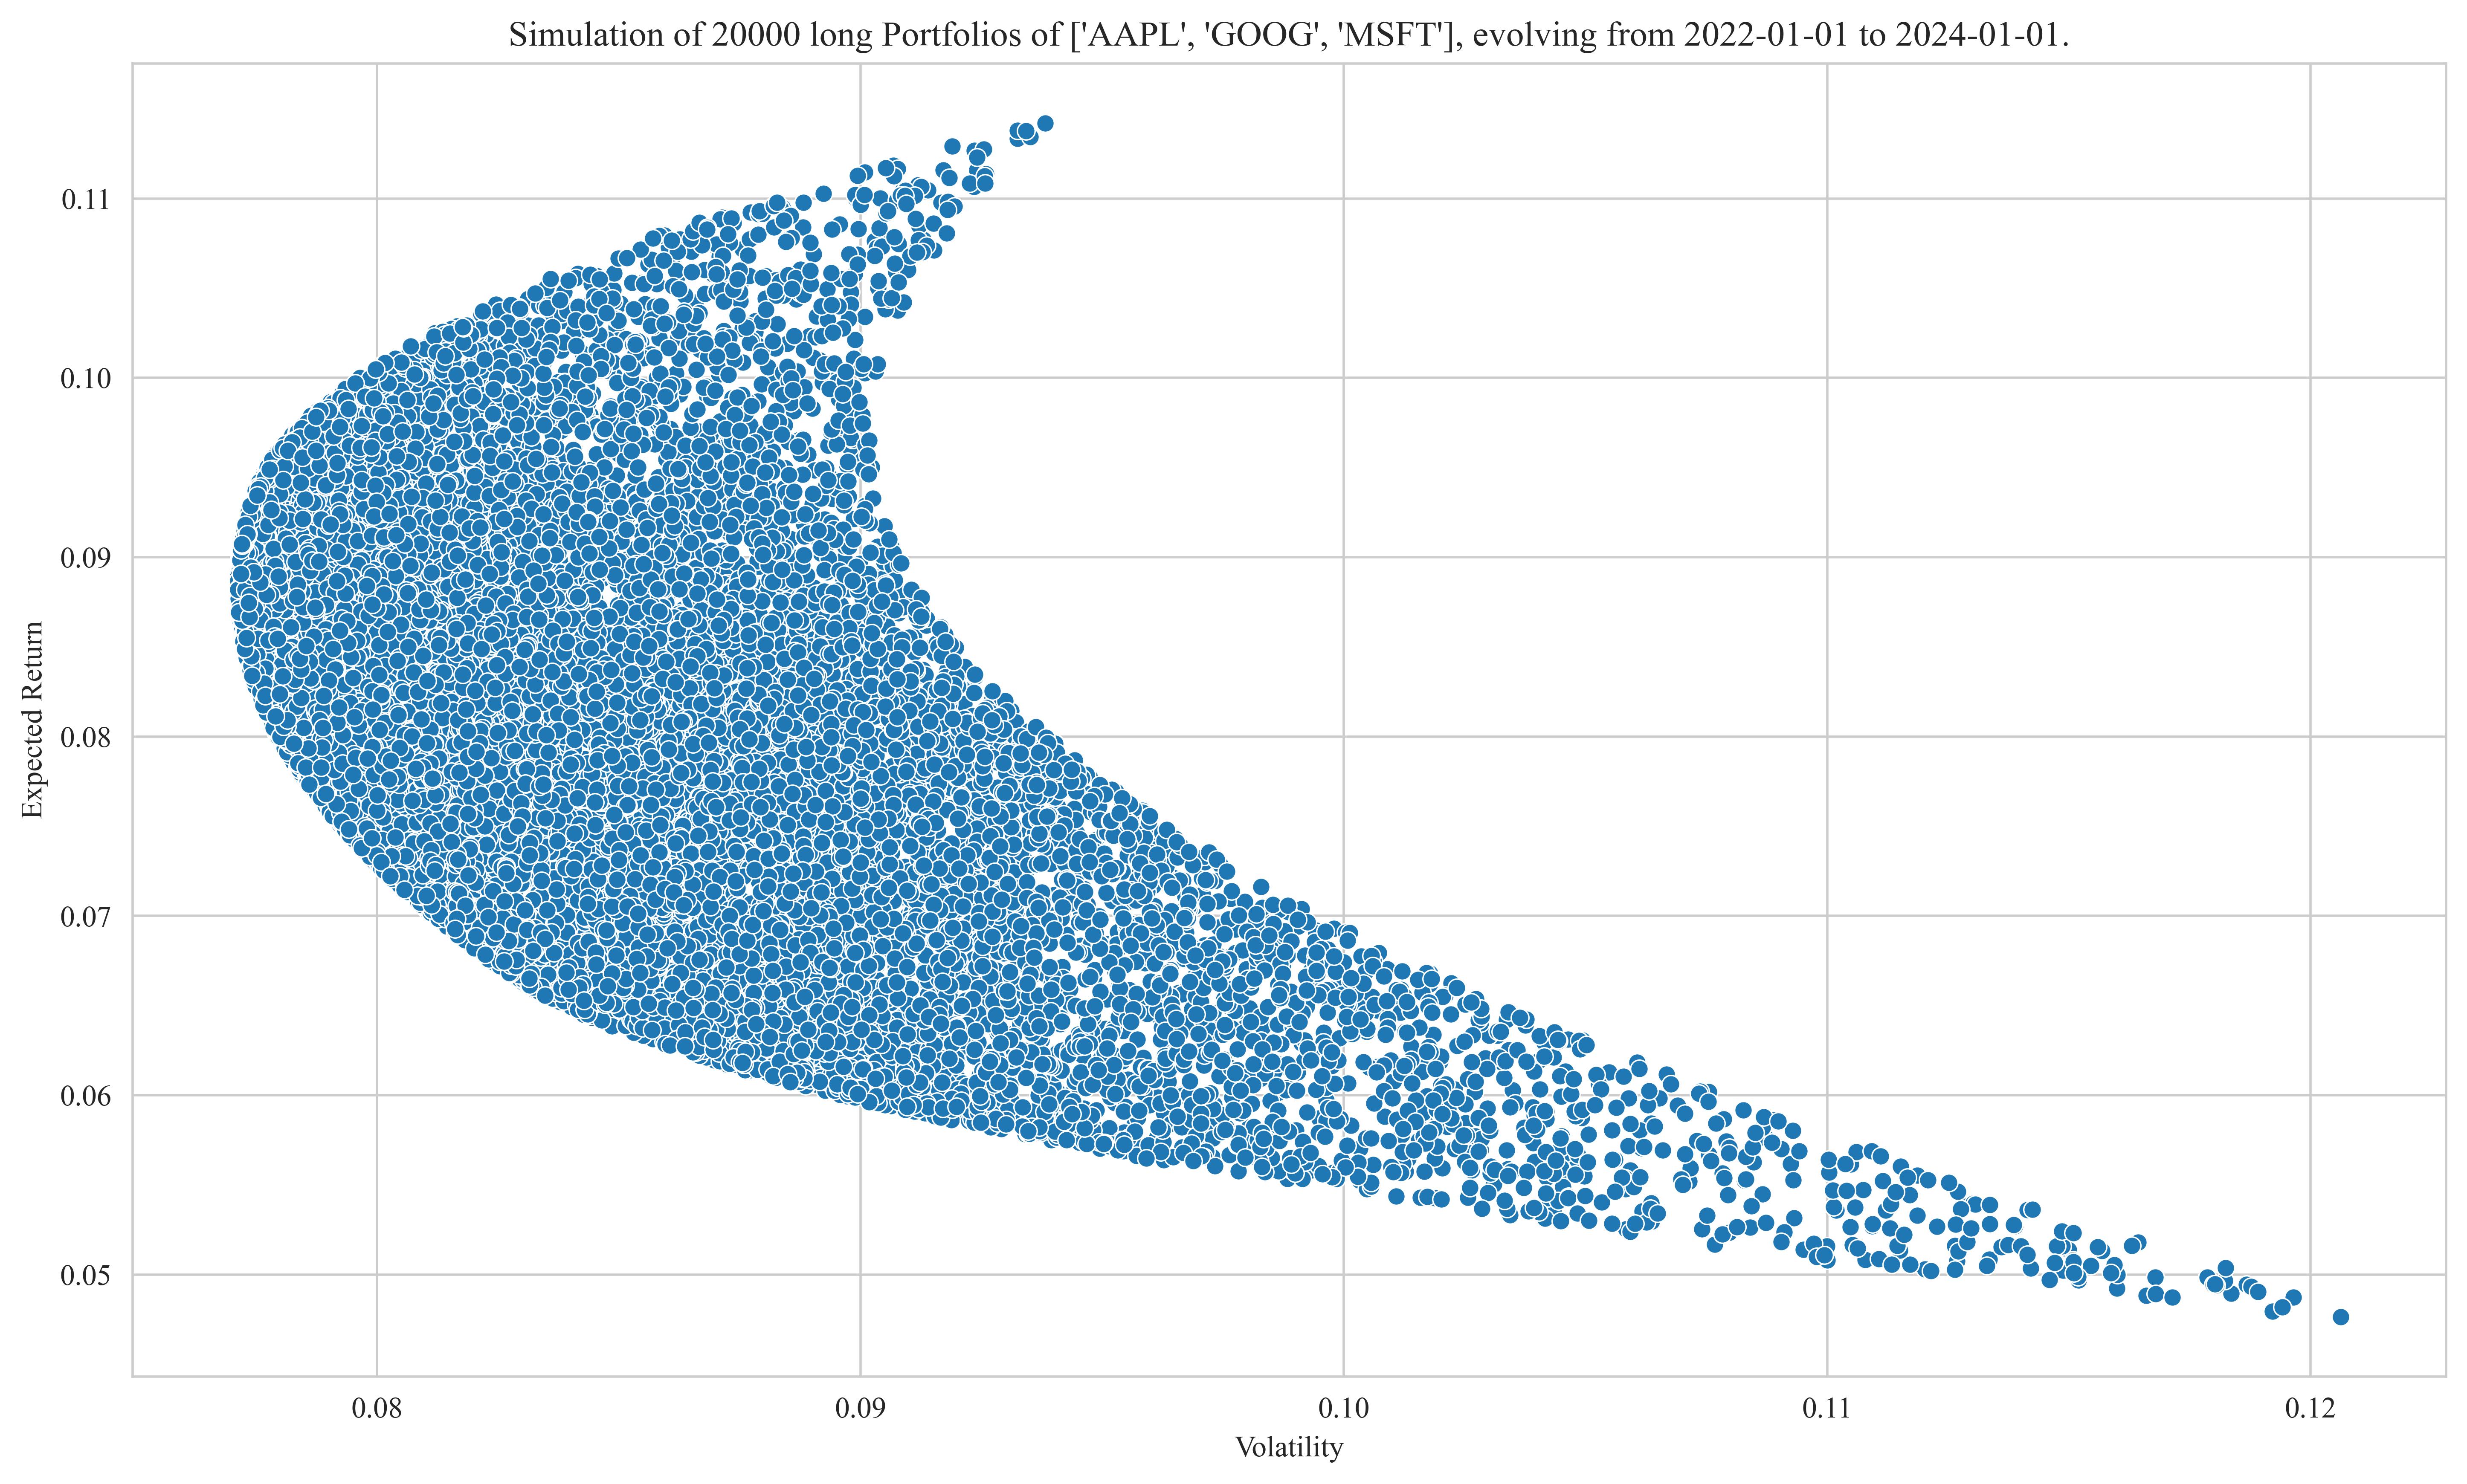

In [85]:
def efficient_frontier(tickers, start_date, end_date, frequency = 1, iterations = 1):
    assert type(tickers) is list and len(tickers) > 0
    n = len(tickers)
    prices = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Adj Close"]
    returns = prices.pct_change()
    Mu = returns.mean() * frequency
    Sigma = returns.cov() * frequency
    x = np.random.uniform(low = 0, high = 1, size = (iterations, n))
    S = np.sum(x, axis = 1)
    w = x / S.reshape((iterations, 1))
    expected_returns = np.dot(w, Mu)
    volatilities = np.diag(np.matmul(np.matmul(w, Sigma), w.T))
    ef = pd.DataFrame({
        "Volatilities" : volatilities,
        "Expected Returns" : expected_returns
    })
    return ef

tickers = ["AAPL", "GOOG", "MSFT"]
end_date = "2024-01-01"
start_date = "2022-01-01"
freq = 252
N = 20000

EF = efficient_frontier(tickers, start_date, end_date, freq, N)

fig, ax = plt.subplots(figsize = (14, 8), dpi = 500)
sns.scatterplot(data = EF, x = "Volatilities", y = "Expected Returns")
ax.set(xlabel = "Volatility", ylabel = "Expected Return", title = f"Simulation of {N} long Portfolios of {tickers}, evolving from {start_date} to {end_date}.")
plt.show()

### **Maximum Sharpe Ratio and Minimum Volatility Portfolios**
**(TO BE COMPLETED!)**

## **Credits**
- The original code is provided as-is in this project by Zakaria Zerrouki
- **(TO BE COMPLETED!)**